# **Multiclass Classification**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# **Data Loading**

In [ ]:
data_folders = {
    'multiclass': 'multiclass'}

# **Preprocessing Pipeline**

A preprocessing function was implemented to standardize the input data:
- Images in the dataset were converted from BGR or RGB,
- resized to a 224x224 dimension,
- and the pixel values were normalized to the range 0-1.

In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0

        return img

    except:
        return None

In [ ]:
X_multiclass = []
y_multiclass = []

def load_and_preprocess_dataset(folder_path, target_list_X, target_list_y, class_mapping=None):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            print(f"  Processing class: {class_name}")
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    preprocessed_img = preprocess_image(img_path)
                    if preprocessed_img is not None:
                        target_list_X.append(preprocessed_img)
                        if class_mapping is not None:
                            target_list_y.append(class_mapping[class_name])
                        else:
                            # simple 0/1 for binary set
                            target_list_y.append(0 if class_name == sorted(os.listdir(folder_path))[0] else 1)

In [ ]:
# multiclass set
multiclass_dataset_path = data_folders['multiclass']
multiclass_classes = sorted([d for d in os.listdir(multiclass_dataset_path) if os.path.isdir(os.path.join(multiclass_dataset_path, d))])
multiclass_class_map = {class_name: i for i, class_name in enumerate(multiclass_classes)}
print(f"Multiclass Class Mapping: {multiclass_class_map}")

load_and_preprocess_dataset(multiclass_dataset_path, X_multiclass, y_multiclass, class_mapping=multiclass_class_map)

X_multiclass = np.array(X_multiclass)
y_multiclass = np.array(y_multiclass)
print(f"Multiclass Dataset - X_multiclass shape: {X_multiclass.shape}, y_multiclass shape: {y_multiclass.shape}")

Multiclass Class Mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}
  Processing class: glass
  Processing class: plastic
  Processing class: cardboard
  Processing class: metal
  Processing class: paper
Multiclass Dataset - X_multiclass shape: (2460, 224, 224, 3), y_multiclass shape: (2460,)


# **The Models**
2 models:
- a custom **CNN model**,
- and a **transfer learning model (MobileNetV2)** which was used to address the limitations observed in the first one.

The dataset contains **2460 images** across **5 classes**: Cardboard, Glass, Metal, Paper, and Plastic.

In [ ]:
print(f"Multiclass data shape: X={X_multiclass.shape}, y={y_multiclass.shape}")
print(f"Number of classes: {len(multiclass_class_map)}")
print(f"Classes: {list(multiclass_class_map.keys())}")

Multiclass data shape: X=(2460, 224, 224, 3), y=(2460,)
Number of classes: 5
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


## **Data Splitting**
The dataset was split into 3 sets for robust evaluation:
1. **Training set**: 1574 images (64%)
2. **Validation set**: 394 images (16%)
3. **Test set**: 492 images (20%)

In [ ]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiclass, y_multiclass,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass
)

X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
    X_train_multi, y_train_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_train_multi
)

# one-hot encoding
num_classes = len(multiclass_class_map)
y_train_multi_cat = to_categorical(y_train_multi, num_classes)
y_test_multi_cat = to_categorical(y_test_multi, num_classes)
y_val_multi_cat = to_categorical(y_val_multi, num_classes)

print(f"Training set: {len(X_train_multi)} images")
print(f"Validation set: {len(X_val_multi)} images")
print(f"Test set: {len(X_test_multi)} images")
print(f"Training class distribution: {np.bincount(y_train_multi)}")
print(f"Validation class distribution: {np.bincount(y_val_multi)}")
print(f"Test class distribution: {np.bincount(y_test_multi)}")

Training set: 1574 images
Validation set: 394 images
Test set: 492 images
Training class distribution: [258 321 262 380 353]
Validation class distribution: [64 80 66 95 89]
Test class distribution: [ 81 100  82 119 110]


## **Data Augmentation**
`ImageDataGenerator` was implemented in the training set to prevent overfitting and improve generalization.

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train_multi,
    y_train_multi_cat,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val_multi,
    y_val_multi_cat,
    batch_size=32
)

# **Model 1**: Simple CNN
The first approach was to build and train a simple convolutional neural network model to see how it performs and to build a baseline.

### **Model Architecture**
- A sequential model with 5 convolutional layers (`Conv2D`).
- Each block includes:
    - ReLu activation.
    - Batch normalization to prevent overfitting.
    - Max pooling to reduce dimensions.
- the filter size increases each layer to capture the increasingly complex features.
- The actual model uses Flatten() to convert from 2 dimensional to 1 dimensional, then followed by Dense layers with Dropout to prevent overfitting.

### **Custom weights**
- Weights were assigned to each class based on our previous models using trials and error.
- In the beginning, many classes were predicted wrong as plastic, so we adjusted the class weight to prevent it from dominating all the classes.
- After that I looked at the confusion matrix and made a few adjustments until I found the best weights.

### **Model Performance**
- The custom CNN model has a test accuracy of 74% with a loss of 67%
- Looking at our confusion matrix, we can see that the result is decent, but the model could still be improved.



In [ ]:
# Build CNN model for multiclass classification
multiclass_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

multiclass_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

multiclass_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,208,133 (58.01 MB)

 Trainable params: 15,206,149 (58.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
manual_weights = {
    0: 1.2,
    1: 1.1,
    2: 1.0,
    3: 1.2,
    4: 0.7
}

## **Model 1**: Model Training

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_multi = multiclass_model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=manual_weights,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.6581 - loss: 0.8869 - val_accuracy: 0.4975 - val_loss: 1.6191
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.6336 - loss: 0.9429 - val_accuracy: 0.4569 - val_loss: 1.5655
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.6774 - loss: 0.8980 - val_accuracy: 0.4594 - val_loss: 1.7015
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.6702 - loss: 0.8674 - val_accuracy: 0.5152 - val_loss: 1.5075
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.6594 - loss: 0.8721 - val_accuracy: 0.3832 - val_loss: 2.4415
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step - accuracy: 0.6765 - loss: 0.9244 - val_accuracy: 0.4365 - val_loss: 1.4880
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6507 - loss: 0.9024 - val_accuracy: 0.4492 - val_loss: 1.7568
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.7022 - loss: 0.8267 - val_accu

In [ ]:
multiclass_model.save("/content/drive/MyDrive/Year 3/y3_1/AIML/aiml group project/multiclass_model.keras")

## **Model 1**: Evaluate

In [ ]:
test_acc, test_loss = multiclass_model.evaluate(X_train_multi, y_train_multi_cat)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7454 - loss: 0.6779


## **Model 1**: Predict

In [ ]:
y_pred_raw = multiclass_model.predict(X_test_multi)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


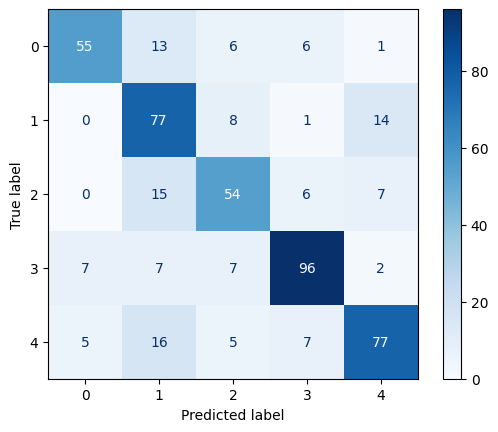

              precision    recall  f1-score   support

           0       0.82      0.68      0.74        81
           1       0.60      0.77      0.68       100
           2       0.68      0.66      0.67        82
           3       0.83      0.81      0.82       119
           4       0.76      0.70      0.73       110

    accuracy                           0.73       492
   macro avg       0.74      0.72      0.73       492
weighted avg       0.74      0.73      0.73       492



In [ ]:
y_pred_classes = np.argmax(y_pred_raw, axis=1)
y_true_classes = np.argmax(y_test_multi_cat, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

cr = classification_report(y_true_classes, y_pred_classes)
print(cr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


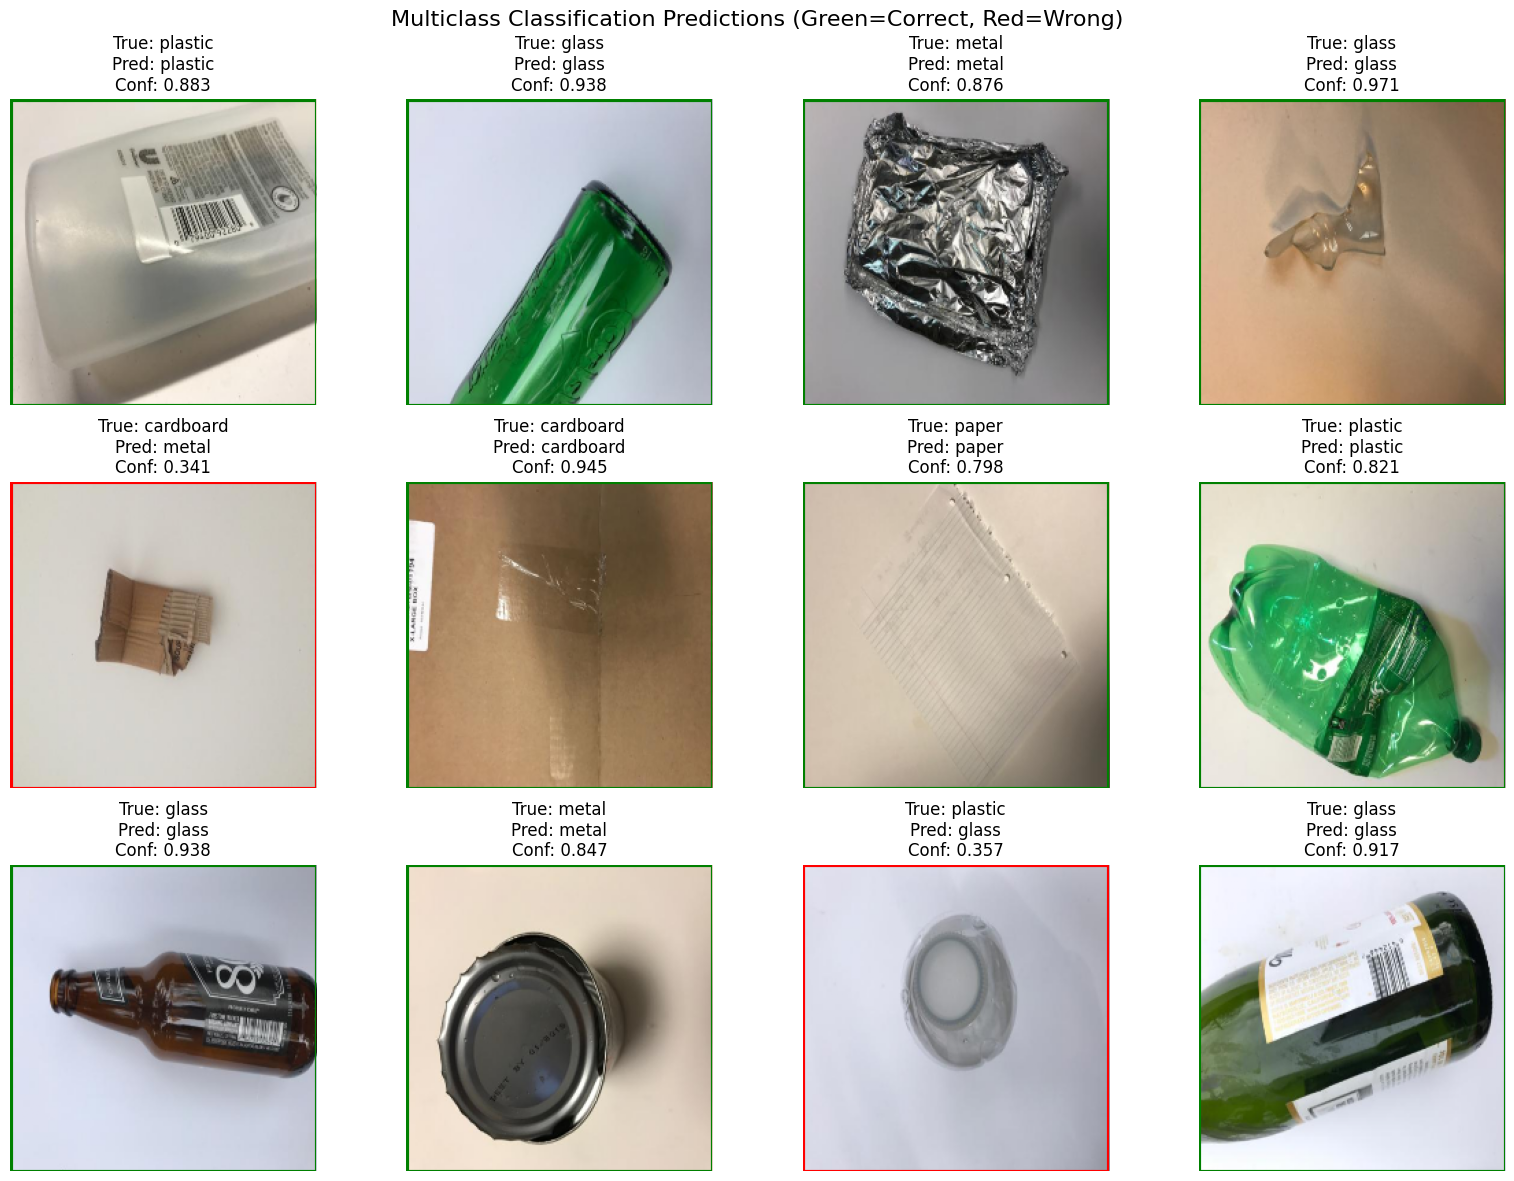

In [ ]:
# Show sample predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

indices = np.random.choice(len(X_test_multi), 12, replace=False)

for i, idx in enumerate(indices):
    # image + true label
    img = X_test_multi[idx]
    true_label = multiclass_classes[y_test_multi[idx]]

    # predict
    pred_probs = multiclass_model.predict(np.expand_dims(img, axis=0))[0]
    pred_class_idx = np.argmax(pred_probs)
    pred_label = multiclass_classes[pred_class_idx]
    confidence = pred_probs[pred_class_idx]

    # show
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}')
    axes[i].axis('off')

    # Color border based on correctness
    if pred_label == true_label:
        axes[i].add_patch(plt.Rectangle((0, 0), 224, 224, fill=False, edgecolor='green', linewidth=3))
    else:
        axes[i].add_patch(plt.Rectangle((0, 0), 224, 224, fill=False, edgecolor='red', linewidth=3))

plt.suptitle('Multiclass Classification Predictions (Green=Correct, Red=Wrong)', fontsize=16)
plt.tight_layout()
plt.show()

## **Model 1**: Test on external data
I also tested the model on the dataset from the binary classification from earlier to test robustness of the model and to see whether the model generalizes well
- **Test set used**: Recyclable pictures from binary classification
    - However, the images in the recyclable folder were not labeled and the folder was too large (roughly 11000 pictures)
    - So, I decided to take a sample and manually labeled them for testing.

### **Performance**
The model performed struggled with the unseen data and the accuracy dropped to 43%.



In [ ]:
external_dataset_path = 'Manually_Labeled_Recyclable'

X_external = []
y_external = []

external_class_map = multiclass_class_map

load_and_preprocess_dataset(external_dataset_path, X_external, y_external, class_mapping=external_class_map)

X_external = np.array(X_external)
y_external = np.array(y_external)

print(f"External Dataset\nX_external shape: {X_external.shape}, y_external shape: {y_external.shape}")

  Processing class: metal
  Processing class: glass
  Processing class: plastic
  Processing class: paper
  Processing class: cardboard
External Dataset
X_external shape: (789, 224, 224, 3), y_external shape: (789,)


In [ ]:
# One-hot encode the external true labels
y_external_cat = to_categorical(y_external, num_classes)

In [ ]:
# Make predictions on the external dataset
y_pred_external_raw = multiclass_model.predict(X_external)
y_pred_external_classes = np.argmax(y_pred_external_raw, axis=1)
y_true_external_classes = np.argmax(y_external_cat, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [ ]:
# Evaluate the model on the external dataset
print("\nEvaluation on Manually Labeled External Dataset:")
loss_external, accuracy_external = multiclass_model.evaluate(X_external, y_external_cat, verbose=0)
print(f"Loss: {loss_external:.4f}")
print(f"Accuracy: {accuracy_external:.4f}")


Evaluation on Manually Labeled External Dataset:
Loss: 1.4136
Accuracy: 0.4309



Classification Report:
              precision    recall  f1-score   support

   cardboard       0.73      0.88      0.80       169
       glass       0.21      0.32      0.25       104
       metal       0.17      0.09      0.12       144
       paper       0.35      0.61      0.44       152
     plastic       0.60      0.24      0.34       220

    accuracy                           0.43       789
   macro avg       0.41      0.43      0.39       789
weighted avg       0.45      0.43      0.41       789


Confusion Matrix:


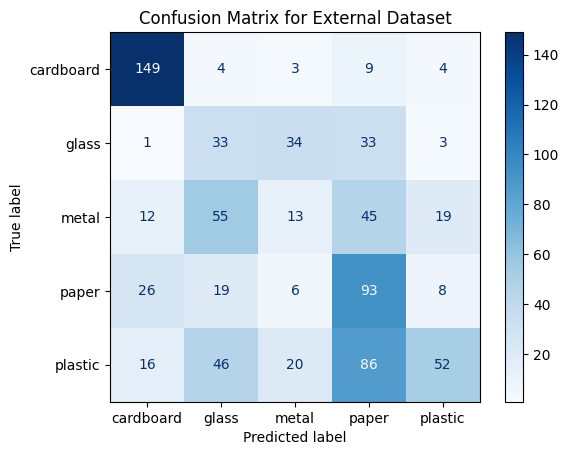

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_external_classes, y_pred_external_classes, target_names=list(multiclass_class_map.keys())))

# Confusion Matrix
print("\nConfusion Matrix:")
cm_external = confusion_matrix(y_true_external_classes, y_pred_external_classes)
disp_external = ConfusionMatrixDisplay(confusion_matrix=cm_external, display_labels=list(multiclass_class_map.keys()))
disp_external.plot(cmap='Blues')
plt.title('Confusion Matrix for External Dataset')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


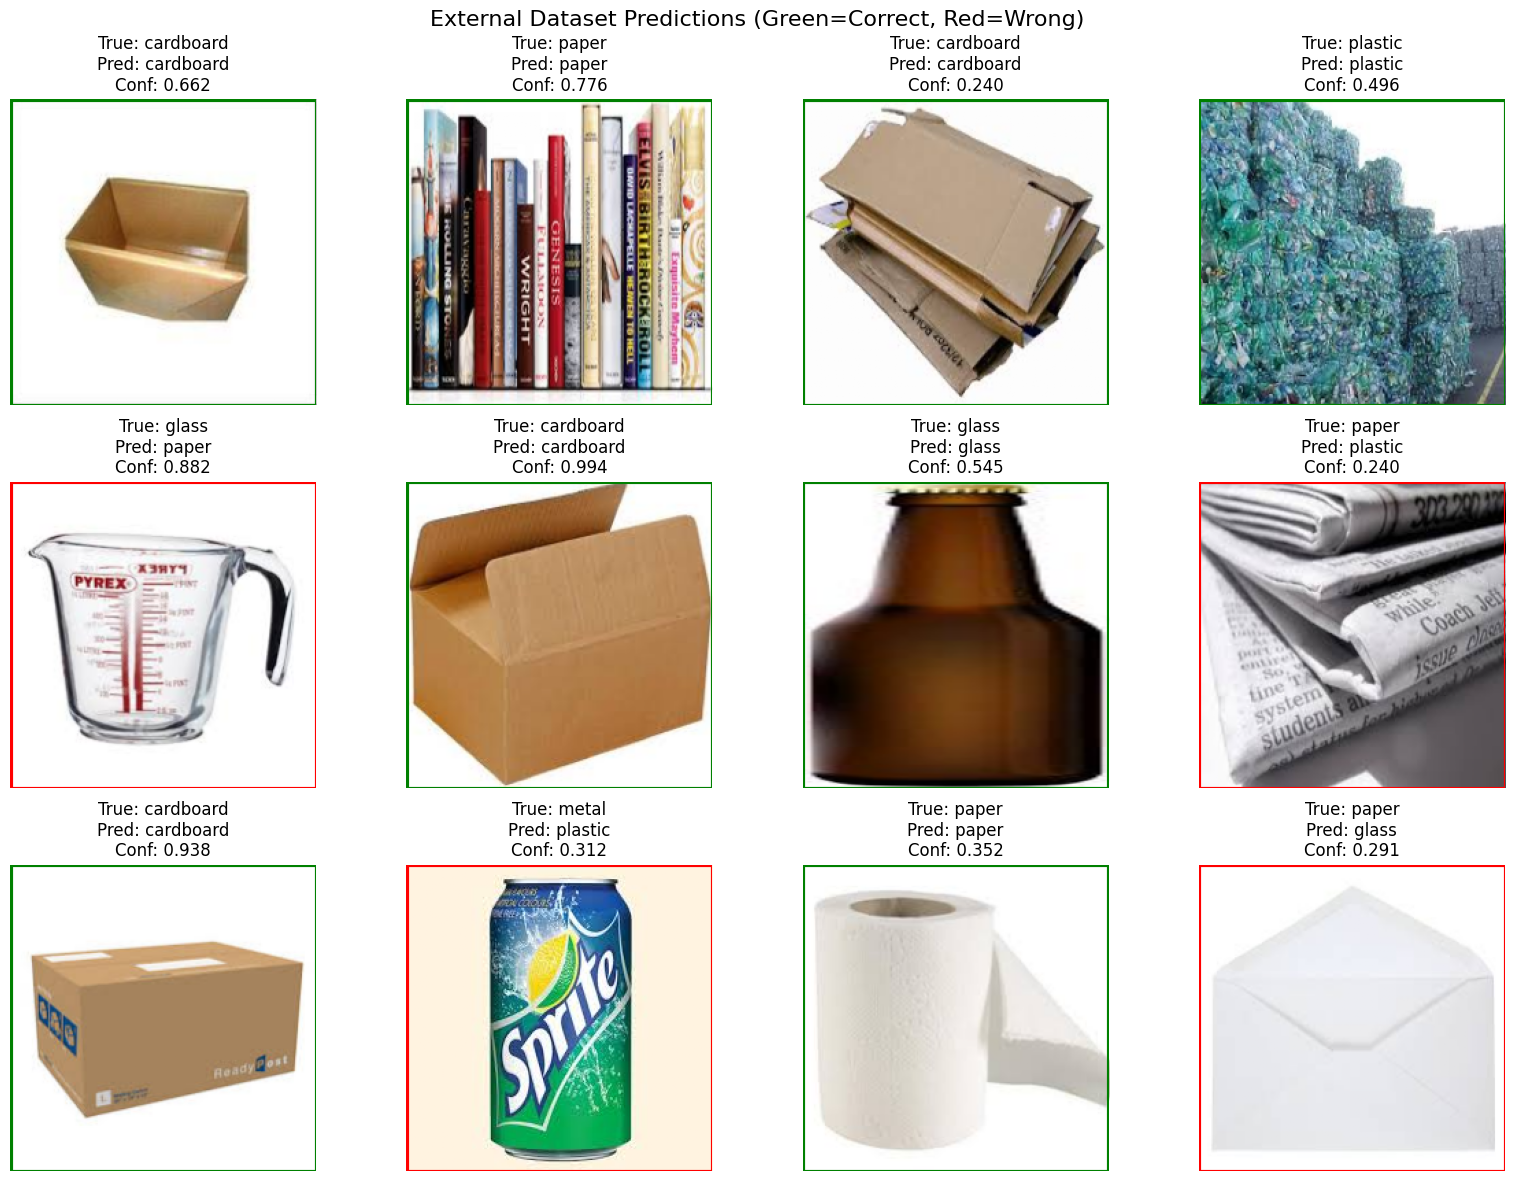

In [ ]:
# Show sample predictions from the external dataset
fig_external, axes_external = plt.subplots(3, 4, figsize=(16, 12))
axes_external = axes_external.ravel()

indices_external = np.random.choice(len(X_external), 12, replace=False)

for i, idx in enumerate(indices_external):
    # Get image and true label
    img_external = X_external[idx]
    true_label_external = multiclass_classes[y_external[idx]]

    # Make prediction
    pred_probs_external = multiclass_model.predict(np.expand_dims(img_external, axis=0))[0]
    pred_class_idx_external = np.argmax(pred_probs_external)
    pred_label_external = multiclass_classes[pred_class_idx_external]
    confidence_external = pred_probs_external[pred_class_idx_external]

    # Display
    axes_external[i].imshow(img_external)
    axes_external[i].set_title(f'True: {true_label_external}\nPred: {pred_label_external}\nConf: {confidence_external:.3f}')
    axes_external[i].axis('off')

    # Color border based on correctness
    if pred_label_external == true_label_external:
        axes_external[i].add_patch(plt.Rectangle((0, 0), 224, 224, fill=False, edgecolor='green', linewidth=3))
    else:
        axes_external[i].add_patch(plt.Rectangle((0, 0), 224, 224, fill=False, edgecolor='red', linewidth=3))

plt.suptitle('External Dataset Predictions (Green=Correct, Red=Wrong)', fontsize=16)
plt.tight_layout()
plt.show()

# **Model 2: MobileNetv2 (transfer learning)**
This model was used due to its ability to extract features from complex textures in the images.

### **Architecture**
- Base model: MobileNetV2 was used as the feature extractor.
    - The top classification layer was excluded
    - and the base layer were frozen to retrain the learned weights.
- Custom classification head:
    - GlobalAveragePooling2D
    - Dense
    - Dropout
    - Softmax output layer

### **Performance**
- **Test accuracy**: the model achieved an accuracy of 88% which was much higher than the other model.
- **Test loss**: the test loss significantly dropped to 0.3881
- The results proved that the pre-trained features from MobileNetV2 has helped with the limitation of our custom CNN model, especially when handling the complexity in the waste material pictures.

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

mobilenetv2_model = Model(inputs=base_model.input, outputs=predictions)

mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenetv2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Model 2**: Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_mobilenet = mobilenetv2_model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    validation_data=val_generator,
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 880ms/step - accuracy: 0.5011 - loss: 1.3062 - val_accuracy: 0.7843 - val_loss: 0.5519
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 376ms/step - accuracy: 0.7275 - loss: 0.6754 - val_accuracy: 0.8198 - val_loss: 0.4927
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.8106 - loss: 0.5396 - val_accuracy: 0.8173 - val_loss: 0.4799
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.8103 - loss: 0.5131 - val_accuracy: 0.8299 - val_loss: 0.4311
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.8486 - loss: 0.3979 - val_accuracy: 0.8452 - val_loss: 0.4078
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.8665 - loss: 0.3669 - val_accuracy: 0.8604 - val_loss: 0.3792
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - accuracy: 0.8651 - loss: 0.3388 - val_accuracy: 0.8503 - val_loss: 0.3751
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.8657 - loss: 0.3629 - val_accu

In [ ]:
multiclass_model.save("/content/drive/MyDrive/Year 3/y3_1/AIML/aiml group project/mobilenetv2_model.keras")

## **Model 2**: Evaluate

In [ ]:
loss_mobilenet, accuracy_mobilenet = mobilenetv2_model.evaluate(X_test_multi, y_test_multi_cat, verbose=0)
print(f"MobileNetV2 Test Loss: {loss_mobilenet:.4f}")
print(f"MobileNetV2 Test Accuracy: {accuracy_mobilenet:.4f}")

MobileNetV2 Test Loss: 0.3881
MobileNetV2 Test Accuracy: 0.8821


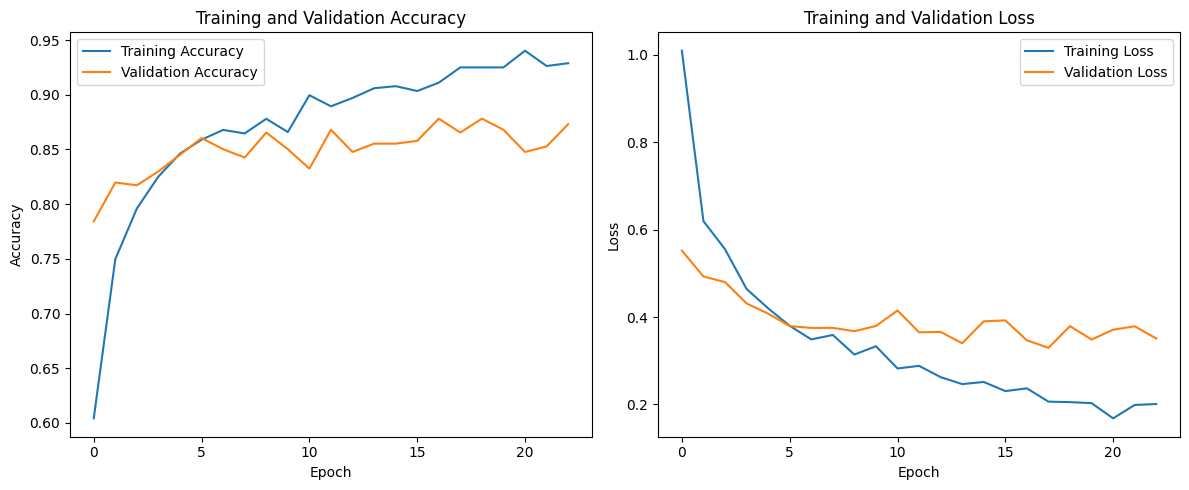

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_mobilenet)

## **Model 2**: predict

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step

MobileNetV2 Classification Report on Test Set:
              precision    recall  f1-score   support

   cardboard       0.95      0.90      0.92        81
       glass       0.83      0.85      0.84       100
       metal       0.87      0.91      0.89        82
       paper       0.88      0.94      0.91       119
     plastic       0.90      0.81      0.85       110

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.88      0.88      0.88       492


MobileNetV2 Confusion Matrix on Test Set:


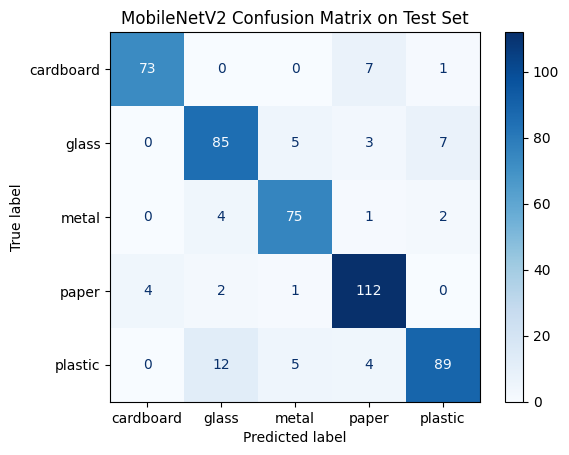

In [ ]:
y_pred_mobilenet_raw = mobilenetv2_model.predict(X_test_multi)
y_pred_mobilenet_classes = np.argmax(y_pred_mobilenet_raw, axis=1)
y_true_test_classes = np.argmax(y_test_multi_cat, axis=1)

print("\nMobileNetV2 Classification Report on Test Set:")
print(classification_report(y_true_test_classes, y_pred_mobilenet_classes, target_names=list(multiclass_class_map.keys())))

print("\nMobileNetV2 Confusion Matrix on Test Set:")
cm_mobilenet = confusion_matrix(y_true_test_classes, y_pred_mobilenet_classes)
disp_mobilenet = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet, display_labels=list(multiclass_class_map.keys()))
disp_mobilenet.plot(cmap='Blues')
plt.title('MobileNetV2 Confusion Matrix on Test Set')
plt.show()

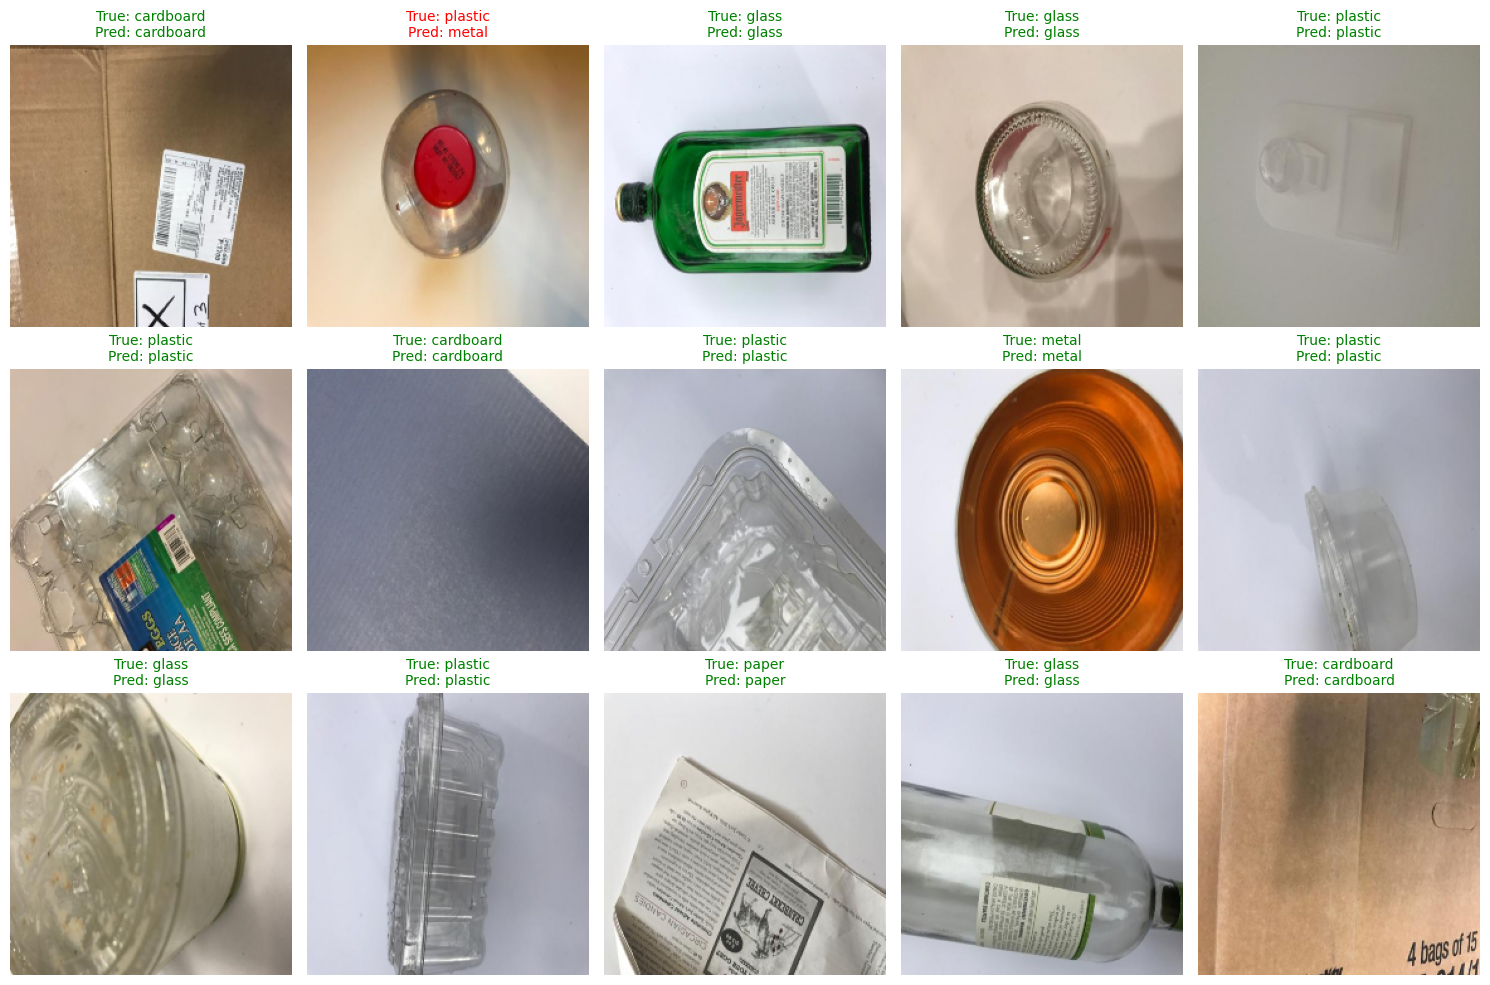

In [ ]:
def visualize_predictions(X_test, y_true, y_pred, class_map, num_samples=15):
    index_to_label = {v: k for k, v in class_map.items()}

    indices = np.random.choice(len(X_test), num_samples, replace=False) 

    rows = 3
    cols = 5
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)

        img = X_test[idx]

        if img.min() < 0:
            img = (img + 1.0) / 2.0

        plt.imshow(np.clip(img, 0, 1)) 
        plt.axis('off')

        # get labels
        true_label = index_to_label[y_true[idx]]
        pred_label = index_to_label[y_pred[idx]]

        # green= correct, red = wrong
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_predictions(
    X_test_multi,
    y_true_test_classes,
    y_pred_mobilenet_classes,
    multiclass_class_map,
    num_samples=15
)

## **Model 2**: Test the model on the manually labeled dataset
Now, I did the same thing was what we did with model 1.
- This MobileNetV2 model was used to predict waste images from the manually labeled dataset (the same one we mentioned earlier).

### **Performance**
The accuracy has improved from 43% to 59%
- Even though the accuracy is still not the best on an external set, it has improved by more than 25 percent.
- 59 percent is significantly more than if it were to be guessed by random chance, which in this case would be 20% since there are 5 classes.

In [ ]:
external_dataset_path = 'recyclable/Manually_Labeled_Recyclable'

X_external = []
y_external = []

external_class_map = multiclass_class_map

load_and_preprocess_dataset(external_dataset_path, X_external, y_external, class_mapping=external_class_map)

X_external = np.array(X_external)
y_external = np.array(y_external)

print(f"External Dataset\nX_external shape: {X_external.shape}, y_external shape: {y_external.shape}")

  Processing class: metal
  Processing class: glass
  Processing class: plastic
  Processing class: paper
  Processing class: cardboard
External Dataset
X_external shape: (789, 224, 224, 3), y_external shape: (789,)


In [ ]:
# One-hot encode the external true labels
y_external_cat = to_categorical(y_external, num_classes)

In [ ]:
# Make predictions on the external dataset
y_pred_external_raw = mobilenetv2_model.predict(X_external)
y_pred_external_classes = np.argmax(y_pred_external_raw, axis=1)
y_true_external_classes = np.argmax(y_external_cat, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 761ms/step


In [ ]:
# Evaluate the model on the external dataset
print("\nEvaluation on Manually Labeled External Dataset:")
loss_external, accuracy_external = mobilenetv2_model.evaluate(X_external, y_external_cat, verbose=0)
print(f"Loss: {loss_external:.4f}")
print(f"Accuracy: {accuracy_external:.4f}")


Evaluation on Manually Labeled External Dataset:
Loss: 1.4158
Accuracy: 0.5894



Classification Report:
              precision    recall  f1-score   support

   cardboard       0.71      0.95      0.82       169
       glass       0.44      0.81      0.57       104
       metal       0.73      0.31      0.43       144
       paper       0.45      0.57      0.50       152
     plastic       0.75      0.40      0.53       220

    accuracy                           0.59       789
   macro avg       0.62      0.61      0.57       789
weighted avg       0.64      0.59      0.57       789


Confusion Matrix:


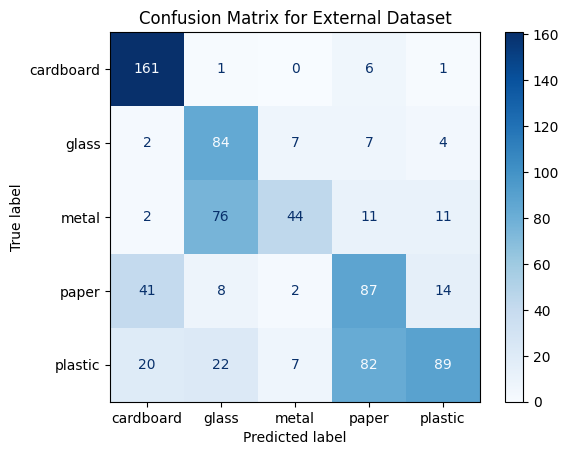

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_external_classes, y_pred_external_classes, target_names=list(multiclass_class_map.keys())))

# Confusion Matrix
print("\nConfusion Matrix:")
cm_external = confusion_matrix(y_true_external_classes, y_pred_external_classes)
disp_external = ConfusionMatrixDisplay(confusion_matrix=cm_external, display_labels=list(multiclass_class_map.keys()))
disp_external.plot(cmap='Blues')
plt.title('Confusion Matrix for External Dataset')
plt.show()

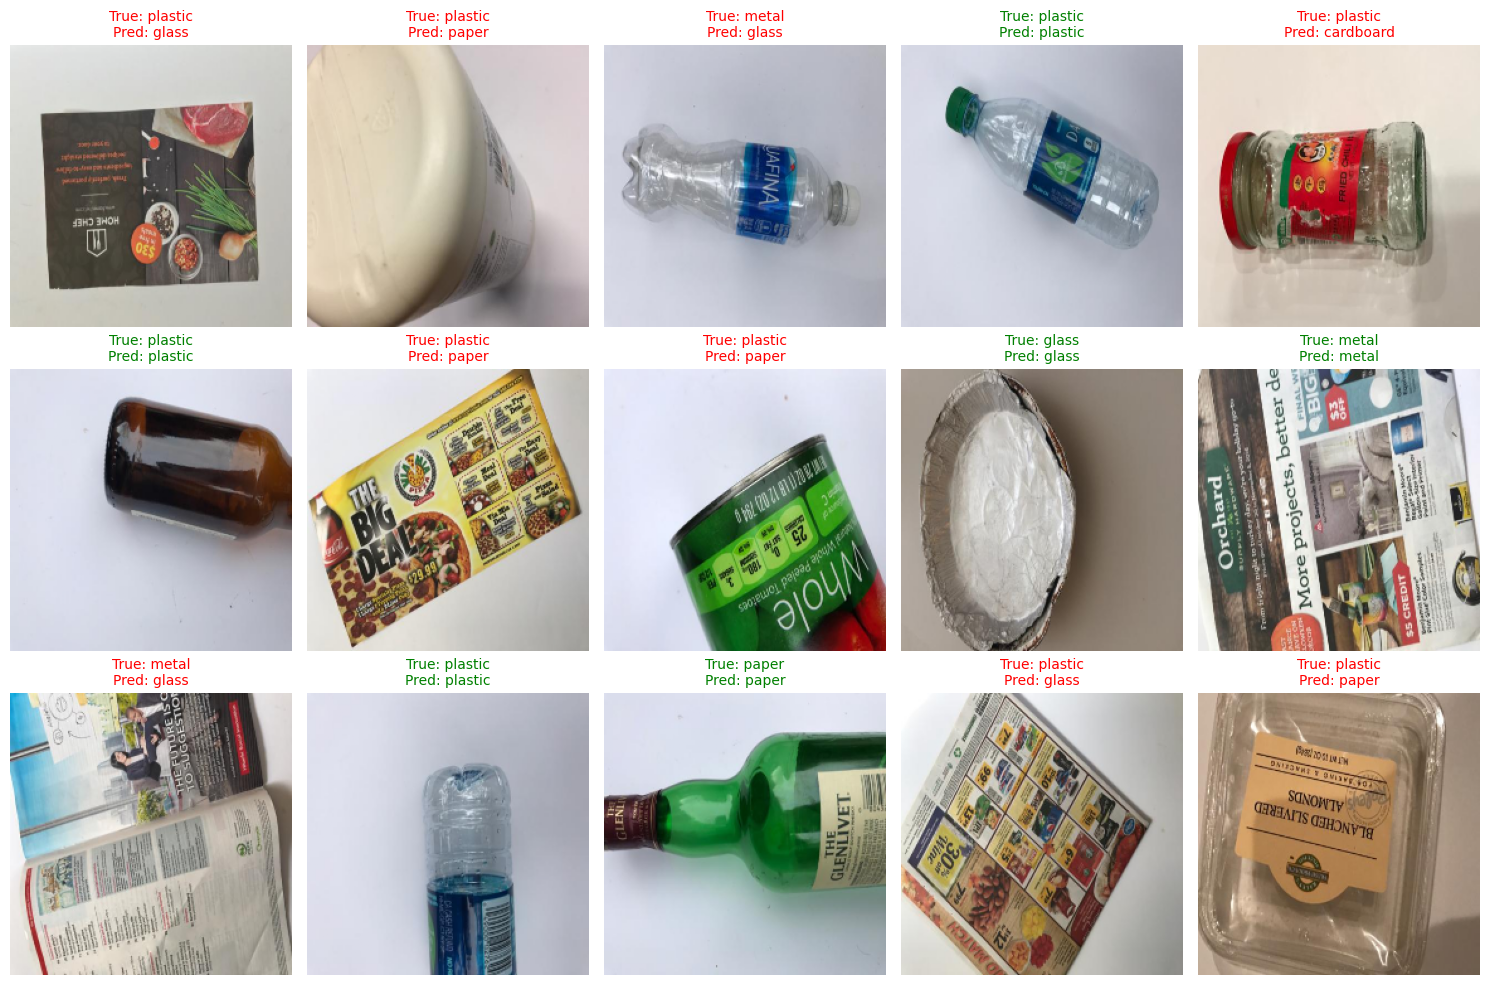

In [ ]:
visualize_predictions(
    X_test_multi,
    y_true_external_classes,
    y_pred_external_classes,
    multiclass_class_map,
    num_samples=15
)